In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/stop_word
!wget 'https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt'

/content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/stop_word
--2022-12-15 17:32:20--  https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘vietnamese-stopwords.txt.16’

vietnamese-stopword     [ <=>                ] 600.82K  --.-KB/s    in 0.04s   

2022-12-15 17:32:21 (13.2 MB/s) - ‘vietnamese-stopwords.txt.16’ saved [615242]



In [22]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


In [23]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [24]:
device = ('cpu', 'cuda')[torch.cuda.is_available()]

%cd /content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/datset
base_csv = 'training.csv'
df = pd.read_csv(base_csv)
df.head()

/content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/datset


,sentence,lable,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0


In [25]:
df['sentence'].size

11500

In [26]:
stop_words = '/content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/stop_word/vietnamese-stopwords.txt'

In [27]:
x_train, y_train = df['sentence'], df['lable']
x_val, y_val = df['sentence'], df['lable']
print(f'shape of train data is {x_train.shape}')
print(f'shape of val data is {x_val.shape}')

shape of train data is (11500,)
shape of val data is (11500,)


In [28]:
len(x_train)

11500

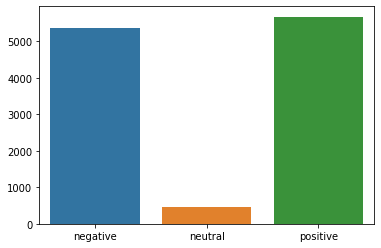

In [29]:
dd = pd.Series(y_train).value_counts().sort_index()
sns.barplot(x=np.array(['negative', 'neutral', 'positive']), y=dd.values)
plt.show()

In [30]:
def preprocess_string(s):
  # Remove all non-word characters (everything except numbers and letters)
  s = re.sub(r"[^\w\s]", '', s)
  # Replace all runs of whitespaces with no space
  s = re.sub(r"\s+", '', s)
  # replace digits with no space
  s = re.sub(r"\d", '', s)

  return s

def tockenize(x_train, y_train, x_val, y_val, stop_words):
  word_list = []

  stop_words = set(stopwords.words(stop_words)) 
  for sent in x_train:
    for word in sent.lower().split():
      word = preprocess_string(word)
      if word not in stop_words and word != '':
        word_list.append(word)

  corpus = Counter(word_list)
  # sorting on the basis of most common words
  corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
  # creating a dict
  onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
  
  # tockenize
  final_list_train, final_list_test = [],[]
  for sent in x_train:
    final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                              if preprocess_string(word) in onehot_dict.keys()])
  for sent in x_val:
    final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                            if preprocess_string(word) in onehot_dict.keys()])
          
  return np.array(final_list_train), np.array(y_train), np.array(final_list_test), np.array(y_val), onehot_dict

In [31]:
# def preprocess_string(text):
#     # remove duplicate characters such as đẹppppppp
#     text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

#     # remove punctuation
#     translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
#     text = text.translate(translator)

#     # remove '_'
#     text = text.replace('_', ' ')

#     # remove numbers
#     text = ''.join([i for i in text if not i.isdigit()])

#     # lower word
#     text = text.lower()

#     # replace special words
#     replace_list = {
#         'ô kêi': ' ok ', 'o kê': ' ok ',
#         'kh ':' không ', 'kô ':' không ', 'hok ':' không ',
#         'kp ': ' không phải ', 'kô ': ' không ', 'ko ': ' không ', 'khong ': ' không ', 'hok ': ' không ',
#     }
#     for k, v in replace_list.items():
#         text = text.replace(k, v)

#     # split texts
#     texts = text.split()

#     if len(texts) < 5:
#         text = None

#     return text

# def tockenize(x_train, y_train, x_val, y_val, stop_words):
#   word_list = []

#   stop_words = set(stopwords.words(stop_words)) 
#   for sent in x_train:
#     for word in sent.lower().split():
#       word = preprocess_string(word)
#       if word not in stop_words and word != '':
#         word_list.append(word)

#   corpus = Counter(word_list)
#   # sorting on the basis of most common words
#   corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
#   # creating a dict
#   onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
  
#   # tockenize
#   final_list_train, final_list_test = [],[]
#   for sent in x_train:
#     final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
#                               if preprocess_string(word) in onehot_dict.keys()])
#   for sent in x_val:
#     final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
#                             if preprocess_string(word) in onehot_dict.keys()])
          
#   return np.array(final_list_train), np.array(y_train), np.array(final_list_test), np.array(y_val), onehot_dict

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
x_train, y_train, x_val, y_val, vocab = tockenize(x_train, y_train, x_val, y_val, stop_words)
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


<ipython-input-30-7027afc80ad5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(y_train), np.array(final_list_test), np.array(y_val), onehot_dict


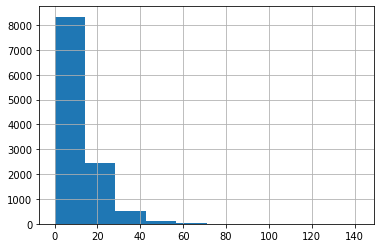

count    11500.000000
mean        12.398696
std          9.295896
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        142.000000
dtype: float64

In [35]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [36]:
def padding_(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len),dtype=int)
  for ii, review in enumerate(sentences):
    if len(review) != 0:
      features[ii, -len(review):] = np.array(review)[:seq_len]
  return features

In [37]:
# we have very less number of reviews with length > 500.
# So we will consideronly those below it.
x_train_pad = padding_(x_train, 500)
x_val_pad = padding_(x_val, 500)

In [38]:
x_train_pad.shape

(11500, 500)

In [39]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

In [43]:
class SentimentRNN(nn.Module):
  def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5):
    super(SentimentRNN,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim

    self.no_layers = no_layers
    self.vocab_size = vocab_size

    # embedding and LSTM layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    #lstm
    self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, batch_first=True)
    
    
    # dropout layer
    self.dropout = nn.Dropout(0.3)

    # linear and sigmoid layer
    self.fc = nn.Linear(self.hidden_dim*2, output_dim)
    
  def forward(self, x, hidden):
    batch_size = x.size(0)
    # embeddings and lstm_out
    embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
    #print(embeds.shape)  #[50, 500, 1000]
    # lstm_out, hidden = self.lstm(embeds, hidden)
    #===========================================
    lstm_out,(h_n,c_n) = self.lstm(embeds,hidden)
    output_fw = h_n[-2, :, :]  
    output_bw = h_n[-1, :, :] 

    output = torch.cat([output_fw, output_bw], dim=-1) 
    out = self.fc(output)
    return F.log_softmax(out,dim=-1),(h_n,c_n)
    #===========================================
    
    # lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
    
    # # dropout and fully connected layer
    # out = self.dropout(lstm_out)
    # out = self.fc(out)

    # # sigmoid function
    # sig_out = nn.functional.log_softmax(out, 1)
    
    # # reshape to be batch_size first
    # sig_out = sig_out.view(batch_size, sig_out.shape[0]//batch_size, self.output_dim)

    # sig_out = sig_out[:, -1, :] # get last batch of labels

    # return last sigmoid output and hidden state
    # return sig_out, hidden
      
      
      
  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

In [44]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 3
hidden_dim = 256

model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


In [45]:
# loss and optimization functions
lr=0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred, label):
  return torch.sum(pred.squeeze().argmax(1) == label.squeeze()).item()

In [ ]:

%cd /content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/model
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()
  # initialize hidden state 
  h = model.init_hidden(batch_size)



  for i, (inputs, labels) in enumerate(train_loader, 1):
    inputs, labels = inputs.to(device), labels.to(device)   
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])
    
    model.zero_grad()

    # if(len(inputs)==batch_size):
    #   output,h= model(inputs,h)

    output, h = model(inputs, h)
    # print('intput ',i,' = ',inputs.shape)
    # calculate the loss and perform backprop
    # import ipdb; ipdb.set_trace()
    loss = criterion(output.squeeze(), labels)
    loss.backward()
    train_losses.append(loss.item())
    # calculating accuracy
    accuracy = acc(output, labels)
    train_acc += accuracy
    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  val_h = model.init_hidden(batch_size)
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:
    val_h = tuple([each.data for each in val_h])

    inputs, labels = inputs.to(device), labels.to(device)

    output, val_h = model(inputs, val_h)
    val_loss = criterion(output.squeeze(), labels)

    val_losses.append(val_loss.item())
    
    accuracy = acc(output, labels)
    val_acc += accuracy
          
  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    torch.save(model.state_dict(), './models_part4.pt')
    print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, epoch_val_loss))
    valid_loss_min = epoch_val_loss
  print(25*'==')

/content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/model
Epoch 1
train_loss : 0.44829283246527546 val_loss : 0.31973110693304435
train_accuracy : 82.99130434782609 val_accuracy : 88.84347826086957
Validation loss decreased (inf --> 0.319731). Saving model ...
Epoch 2
train_loss : 0.3093054311430973 val_loss : 0.2473736542560484
train_accuracy : 89.38260869565218 val_accuracy : 91.87826086956522
Validation loss decreased (0.319731 --> 0.247374). Saving model ...
Epoch 3
train_loss : 0.2569020404763844 val_loss : 0.20824090073937956
train_accuracy : 91.47826086956522 val_accuracy : 93.2695652173913
Validation loss decreased (0.247374 --> 0.208241). Saving model ...
Epoch 4
train_loss : 0.21415124783373396 val_loss : 0.17355590652998376
train_accuracy : 92.98260869565217 val_accuracy : 94.6
Validation loss decreased (0.208241 --> 0.173556). Saving model ...
Epoch 5
train_loss : 0.18414358144383067 val_loss : 0.1352842648797061
train_accuracy : 93.95652173913044 val

In [46]:
%cd /content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/model/
Mymodel = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5)
Mymodel.to(device)
Mymodel.load_state_dict(torch.load('models_part4.pt'))
Mymodel.eval()

/content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/model


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [47]:
import numpy as np
import pandas as pd

%cd /content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/datset/
source = pd.read_csv('test.csv')
sentence = source['sentence']
def predict_text(text):
  
  word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                    if preprocess_string(word) in vocab.keys()])
  word_seq = np.expand_dims(word_seq,axis=0)
  pad =  torch.from_numpy(padding_(word_seq,500))
  inputs = pad.to(device)
  batch_size = 1
  h = Mymodel.init_hidden(batch_size)
  h = tuple([each.data for each in h])
  output, h = Mymodel(inputs, h)
  return output





/content/drive/MyDrive/AI/HIT_Tech/NLP/Sentiment_Analysis/from_huggin_face/datset


In [48]:
labels = ('Tiêu cực','Bình Thường','Tích cực')

In [52]:
input = 'Trên lớp chú ý nghe giảng, có ý thức tốt, hoàn thành bài đầy đủ'
print(input)
labels[predict_text(input).argmax(1).tolist()[0]]

Trên lớp chú ý nghe giảng, có ý thức tốt, hoàn thành bài đầy đủ


'Tích cực'

In [53]:
input = 'Trên lớp chểnh mảng, không tập trung vào bài giảng, chưa có ý thức rèn luyện'
print(input)
labels[predict_text(input).argmax(1).tolist()[0]]

Trên lớp chểnh mảng, không tập trung vào bài giảng, chưa có ý thức rèn luyện


'Tiêu cực'